## **Elaborazione di Immagini Mediche**
### 2021/22 - VESSELWALL SEGMENTATION CHALLENGE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1
!pip install pydicom

# Import

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import segmentation_models as sm
import plotly.express as px
import math

import pydicom
import glob

from datetime import datetime
from tqdm import tqdm

from matplotlib import pyplot as plt

from scipy import ndimage
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
from skimage import morphology
from skimage import filters
from skimage import color,exposure
from skimage import measure

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical, normalize
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.metrics import MeanIoU

import cv2

import re

from segmentation_models import Unet
from segmentation_models.metrics import FScore, IOUScore

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Functions

In [ ]:
def sorted_alphanum_slice(data): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]  
    return sorted(data, key=alphanum_key, reverse=True)
    
def sorted_alphanum_pz(data): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]  
    return sorted(data, key=alphanum_key)

# Preparazione dataset

In [ ]:
!unzip  "/content/drive/MyDrive/Challenge_VWS/DATASET_Final_Right.zip"
!unzip  "/content/drive/MyDrive/Challenge_VWS/DATASET_Final_Left.zip"

In [ ]:
data_type = ('DATASET_Final','RESULTS')
set_type = ('TRAIN','VALIDATION')
side_type = ('_Left','_Right')

path = os.getcwd()

TRAIN_path_l = os.path.join(path,data_type[0]+side_type[0],set_type[0])
VALID_path_l = os.path.join(path,data_type[0]+side_type[0],set_type[1])
TRAIN_path_r = os.path.join(path,data_type[0]+side_type[1],set_type[0])
VALID_path_r = os.path.join(path,data_type[0]+side_type[1],set_type[1])

listOfPz_train_l = sorted_alphanum_pz(os.listdir(TRAIN_path_l)) 
listOfPz_valid_l = sorted_alphanum_pz(os.listdir(VALID_path_l))
listOfPz_train_r = sorted_alphanum_pz(os.listdir(TRAIN_path_r)) 
listOfPz_valid_r = sorted_alphanum_pz(os.listdir(VALID_path_r))

# Preprocessing

In [ ]:
IMG_WIDTH = 360
IMG_HEIGHT = 100
IMG_CHANNELS=3
NUM_CLASSES=3

width = 256
height = 100 
xc = math.ceil(IMG_WIDTH/2)
yc = math.ceil (IMG_HEIGHT/2)

zero_array = np.zeros((14,width), dtype=np.uint8) #CREO UN ARRAY NULLO DA AGGIUNGERE ALL'IMMAGINE PER RIPORTARE LE DIMENSIONI A 128X512 

* Training Left

In [ ]:
X_train = []
Y_train = []
listOfimg_train_l=[]
num_slice_pz_train_left=np.zeros(len(listOfPz_train_l),dtype=int)
for pz, ind in zip(listOfPz_train_l,range(len(num_slice_pz_train_left))):
  print(f" Patient: {pz}")
  images=sorted_alphanum_slice(os.listdir(TRAIN_path_l+'/'+pz))
  num_slice_pz_train_left[ind]=len(images)/2
  for image in tqdm(images):
    if 'mask' in image:
      mask = imread(TRAIN_path_l+'/'+pz+'/'+image)
      mask = mask[0:IMG_HEIGHT, 0:width] 
      mask = np.concatenate((zero_array,mask,zero_array), axis=0) 
      #mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype=np.uint8)
      Y_train.append(mask)
    else:
      img = imread(TRAIN_path_l+'/'+pz+'/'+image)
      img = img[0:IMG_HEIGHT, 0:width] 
      img = np.concatenate((zero_array,img,zero_array), axis=0) 
      p2, p98 = np.percentile(img, (2, 98))
      img = exposure.rescale_intensity(img, in_range=(p2, p98))
      img = ndimage.median_filter(img, size=2, footprint=None)
      X_train.append(img)
      listOfimg_train_l.append(image)

X_train = np.array(X_train)
x,y,z = X_train.shape
X_train_3D_left=np.zeros((x,y,z,IMG_CHANNELS),dtype=np.uint8)
X_train_3D_left[:,:,:,0] = X_train
X_train_3D_left[:,:,:,1] = X_train
X_train_3D_left[:,:,:,2] = X_train

Y_train = np.array(Y_train) 
Y_train = np.expand_dims(Y_train, axis=3)
Y_train_left = to_categorical(Y_train, num_classes=NUM_CLASSES, dtype=bool)

* Training Right

In [ ]:
X_train = []
Y_train = []
new_width=int(IMG_WIDTH-width)
listOfimg_train_r=[]
num_slice_pz_train_right=np.zeros(len(listOfPz_train_r),dtype=int)
for pz, ind in zip(listOfPz_train_r,range(len(num_slice_pz_train_right))):
  print(f" Patient: {pz}")
  images=sorted_alphanum_slice(os.listdir(TRAIN_path_r+'/'+pz))
  num_slice_pz_train_right[ind]=len(images)/2
  for image in tqdm(images):
    if 'mask' in image:
      mask = imread(TRAIN_path_r+'/'+pz+'/'+image)
      mask = mask[0:IMG_HEIGHT, new_width:IMG_WIDTH]
      mask = np.concatenate((zero_array,mask,zero_array), axis=0) 
      Y_train.append(mask)
    else:
      img = imread(TRAIN_path_r+'/'+pz+'/'+image)
      img = img[0:IMG_HEIGHT, new_width:IMG_WIDTH]
      img = np.concatenate((zero_array,img,zero_array), axis=0) 
      p2, p98 = np.percentile(img, (2, 98))
      img = exposure.rescale_intensity(img, in_range=(p2, p98))
      img = ndimage.median_filter(img, size=2, footprint=None)
      X_train.append(img)
      listOfimg_train_r.append(image)

X_train = np.array(X_train)
x,y,z=X_train.shape
X_train_3D_right=np.zeros((x,y,z,IMG_CHANNELS),dtype=np.uint8)
X_train_3D_right[:,:,:,0] = X_train
X_train_3D_right[:,:,:,1] = X_train
X_train_3D_right[:,:,:,2] = X_train

Y_train = np.array(Y_train) 
Y_train = np.expand_dims(Y_train, axis=3)
Y_train_right = to_categorical(Y_train, num_classes=NUM_CLASSES, dtype=bool)

* Validation Left

In [ ]:
X_val = []
Y_val = []
listOfimg_val_l=[]
num_slice_pz_valid_left=np.zeros(len(listOfPz_valid_l),dtype=int)
for pz, ind in zip(listOfPz_valid_l,range(len(num_slice_pz_valid_left))):
  print(f" Patient: {pz}")
  images=sorted_alphanum_slice(os.listdir(VALID_path_l+'/'+pz))
  num_slice_pz_valid_left[ind]=len(images)/2
  for image in tqdm(images):
    if 'mask' in image:
      mask = imread(VALID_path_l+'/'+pz+'/'+image)
      mask = mask[0:IMG_HEIGHT, 0:width]  
      mask = np.concatenate((zero_array,mask,zero_array), axis=0) 
      #mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype=np.uint8) 
      Y_val.append(mask)
    else:
      img = imread(VALID_path_l+'/'+pz+'/'+image)
      img = img[0:IMG_HEIGHT, 0:width] 
      img = np.concatenate((zero_array,img,zero_array), axis=0) 
      p2, p98 = np.percentile(img, (2, 98))
      img = exposure.rescale_intensity(img, in_range=(p2, p98))
      img = ndimage.median_filter(img, size=2, footprint=None)
      X_val.append(img)
      listOfimg_val_l.append(image)

X_val = np.array(X_val)
x,y,z=X_val.shape
X_val_3D_left=np.zeros((x,y,z,IMG_CHANNELS),dtype=np.uint8)
X_val_3D_left[:,:,:,0] = X_val
X_val_3D_left[:,:,:,1] = X_val
X_val_3D_left[:,:,:,2] = X_val

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=3)
Y_val_left = to_categorical(Y_val, num_classes=NUM_CLASSES, dtype=bool)

 Patient: 0_P4_U


100%|██████████| 136/136 [00:00<00:00, 357.50it/s]


 Patient: 0_P12_U


100%|██████████| 248/248 [00:00<00:00, 353.77it/s]


 Patient: 0_P19_U


100%|██████████| 62/62 [00:00<00:00, 331.67it/s]


 Patient: 0_P27_U


100%|██████████| 74/74 [00:00<00:00, 359.18it/s]


 Patient: 0_P36_U


100%|██████████| 134/134 [00:00<00:00, 336.01it/s]


* Validation Right

In [ ]:
X_val = []
Y_val = []
listOfimg_val_r=[]
num_slice_pz_valid_right=np.zeros(len(listOfPz_valid_r),dtype=int)
for pz, ind in zip(listOfPz_valid_r,range(len(num_slice_pz_valid_right))):
  print(f" Patient: {pz}")
  images=sorted_alphanum_slice(os.listdir(VALID_path_r+'/'+pz))
  num_slice_pz_valid_right[ind]=len(images)/2
  for image in tqdm(images):
    if 'mask' in image:
      mask = imread(VALID_path_r+'/'+pz+'/'+image)
      mask = mask[0:IMG_HEIGHT, new_width:IMG_WIDTH]
      mask = np.concatenate((zero_array,mask,zero_array), axis=0) 
      #mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype=np.uint8) 
      Y_val.append(mask)
    else:
      img = imread(VALID_path_r+'/'+pz+'/'+image)
      img = img[0:IMG_HEIGHT, new_width:IMG_WIDTH]
      img = np.concatenate((zero_array,img,zero_array), axis=0) 
      p2, p98 = np.percentile(img, (2, 98))
      img = exposure.rescale_intensity(img, in_range=(p2, p98))
      img = ndimage.median_filter(img, size=2, footprint=None)
      X_val.append(img)
      listOfimg_val_r.append(image)

X_val = np.array(X_val)
x,y,z=X_val.shape
X_val_3D_right=np.zeros((x,y,z,IMG_CHANNELS),dtype=np.uint8)
X_val_3D_right[:,:,:,0] = X_val
X_val_3D_right[:,:,:,1] = X_val
X_val_3D_right[:,:,:,2] = X_val

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=3)
Y_val_right = to_categorical(Y_val, num_classes=NUM_CLASSES, dtype=bool)

 Patient: 0_P4_U


0it [00:00, ?it/s]


 Patient: 0_P12_U


100%|██████████| 262/262 [00:01<00:00, 233.98it/s]


 Patient: 0_P19_U


100%|██████████| 126/126 [00:00<00:00, 146.36it/s]


 Patient: 0_P27_U


100%|██████████| 48/48 [00:00<00:00, 203.20it/s]


 Patient: 0_P36_U


100%|██████████| 102/102 [00:00<00:00, 166.78it/s]


# Model



### Model loading

In [ ]:
!unzip  "/content/drive/MyDrive/Challenge_VWS/Models.zip"

In [ ]:
models_path = 'Models'
filename_model_left = 'model_Unet_resnet34_Left.hdf5'
filename_model_right = 'model_Unet_resnet34_Right.hdf5'

model_dir_l = os.path.join(path,models_path,filename_model_left)
model_l= load_model(model_dir_l, compile=False)

model_dir_r = os.path.join(path,models_path,filename_model_right)
model_r = load_model(model_dir_r, compile=False)

### Masks prediction

In [ ]:
# Calcolo maschere automatiche per validation
x,y,z,k = Y_val_left.shape
Mask_auto_val_left = np.zeros((x,y,z,k),dtype=np.uint8)

cont_slice=0
for s in tqdm(X_val_3D_left):
    img1 = np.reshape(s,(1,128,256,3))
    softmax = model_l.predict(img1)

    mask_auto = softmax
    mask_auto[mask_auto<0.5] = 0
    mask_auto[mask_auto>=0.5] = 1

    # Save mask auto
    Mask_auto_val_left[cont_slice] = mask_auto
    cont_slice+=1

#Calcolo maschere automatiche per training
x,y,z,k=Y_train_left.shape
Mask_auto_train_left=np.zeros((x,y,z,k),dtype=np.uint8)

cont_slice=0
for s in tqdm(X_train_3D_left):
    img1 = np.reshape(s,(1,128,256,3))
    softmax = model_l.predict(img1)
    
    
    mask_auto = softmax
    mask_auto[mask_auto<0.5] = 0
    mask_auto[mask_auto>=0.5] = 1

    # Save mask auto
    Mask_auto_train_left[cont_slice] = mask_auto
    cont_slice+=1


# Calcolo maschere automatiche per validation right
x,y,z,k=Y_val_right.shape
Mask_auto_val_right=np.zeros((x,y,z,k),dtype=np.uint8)

cont_slice=0
for s in tqdm(X_val_3D_right):
    img1 = np.reshape(s,(1,128,256,3))
    softmax = model_r.predict(img1)
    
    
    mask_auto = softmax
    mask_auto[mask_auto<0.5] = 0
    mask_auto[mask_auto>=0.5] = 1

    # Save mask auto
    Mask_auto_val_right[cont_slice] = mask_auto
    cont_slice+=1

#Calcolo maschere automatiche per training
x,y,z,k=Y_train_right.shape
Mask_auto_train_right=np.zeros((x,y,z,k),dtype=np.uint8)

cont_slice=0
for s in tqdm(X_train_3D_right):
    img1 = np.reshape(s,(1,128,256,3))
    softmax = model_r.predict(img1)
     
    mask_auto = softmax
    mask_auto[mask_auto<0.5] = 0
    mask_auto[mask_auto>=0.5] = 1

    # Save mask auto
    Mask_auto_train_right[cont_slice] = mask_auto
    cont_slice+=1


 16%|█▌        | 275/1723 [00:08<00:43, 33.03it/s]

In [ ]:
Mask_auto_train_left_backup = np.copy(Mask_auto_train_left)
Mask_auto_train_right_backup = np.copy(Mask_auto_train_right)
Mask_auto_val_left_backup = np.copy(Mask_auto_val_left)
Mask_auto_val_right_backup = np.copy(Mask_auto_val_right)

# Post Processing

In [ ]:
#LEFT:

# Validation
Mask_auto_val_new=np.zeros_like(Mask_auto_val_left,dtype=bool)
Mask_auto_val_new[Mask_auto_val_left==0]=False
Mask_auto_val_new[Mask_auto_val_left==1]=True


for n_slice in (range(len(Mask_auto_val_new[:,:,:,2]))):
  Mask_auto_val_new[n_slice,:,:,1]=morphology.remove_small_holes(Mask_auto_val_new[n_slice,:,:,1],area_threshold=100,connectivity=3)
  Mask_auto_val_new[n_slice,:,:,1]=morphology.remove_small_objects(Mask_auto_val_new[n_slice,:,:,1],min_size=40)
  Mask_auto_val_new[n_slice,:,:,2]=morphology.remove_small_holes(Mask_auto_val_new[n_slice,:,:,2],area_threshold=64)
  Mask_auto_val_new[n_slice,:,:,2]=morphology.remove_small_objects(Mask_auto_val_new[n_slice,:,:,2],min_size=40)

Mask_auto_val_left[Mask_auto_val_new==False]=0
Mask_auto_val_left[Mask_auto_val_new==True]=1


# Training
Mask_auto_train_new=np.zeros_like(Mask_auto_train_left,dtype=bool)
Mask_auto_train_new[Mask_auto_train_left==0]=False
Mask_auto_train_new[Mask_auto_train_left==1]=True

for n_slice in (range(len(Mask_auto_train_new[:,:,:,2]))):
  Mask_auto_train_new[n_slice,:,:,1]=morphology.remove_small_holes(Mask_auto_train_new[n_slice,:,:,1],area_threshold=100,connectivity=2)
  Mask_auto_train_new[n_slice,:,:,1]=morphology.remove_small_objects(Mask_auto_train_new[n_slice,:,:,1],min_size=40)
  Mask_auto_train_new[n_slice,:,:,2]=morphology.remove_small_holes(Mask_auto_train_new[n_slice,:,:,2],area_threshold=64)
  Mask_auto_train_new[n_slice,:,:,2]=morphology.remove_small_objects(Mask_auto_train_new[n_slice,:,:,2],min_size=40)


Mask_auto_train_left[Mask_auto_train_new==False]=0
Mask_auto_train_left[Mask_auto_train_new==True]=1

#RIGHT:

# Validation
Mask_auto_val_new=np.zeros_like(Mask_auto_val_right,dtype=bool)
Mask_auto_val_new[Mask_auto_val_right==0]=False
Mask_auto_val_new[Mask_auto_val_right==1]=True

for n_slice in (range(len(Mask_auto_val_new[:,:,:,2]))):
  Mask_auto_val_new[n_slice,:,:,1]=morphology.remove_small_holes(Mask_auto_val_new[n_slice,:,:,1],area_threshold=100,connectivity=3)
  Mask_auto_val_new[n_slice,:,:,1]=morphology.remove_small_objects(Mask_auto_val_new[n_slice,:,:,1],min_size=40)
  Mask_auto_val_new[n_slice,:,:,2]=morphology.remove_small_holes(Mask_auto_val_new[n_slice,:,:,2],area_threshold=64)
  Mask_auto_val_new[n_slice,:,:,2]=morphology.remove_small_objects(Mask_auto_val_new[n_slice,:,:,2],min_size=40)


Mask_auto_val_right[Mask_auto_val_new==False]=0
Mask_auto_val_right[Mask_auto_val_new==True]=1

# Training
Mask_auto_train_new=np.zeros_like(Mask_auto_train_right,dtype=bool)
Mask_auto_train_new[Mask_auto_train_right==0]=False
Mask_auto_train_new[Mask_auto_train_right==1]=True

for n_slice in (range(len(Mask_auto_train_new[:,:,:,2]))):
  Mask_auto_train_new[n_slice,:,:,1]=morphology.remove_small_holes(Mask_auto_train_new[n_slice,:,:,1],area_threshold=100,connectivity=2)
  Mask_auto_train_new[n_slice,:,:,1]=morphology.remove_small_objects(Mask_auto_train_new[n_slice,:,:,1],min_size=40)
  Mask_auto_train_new[n_slice,:,:,2]=morphology.remove_small_holes(Mask_auto_train_new[n_slice,:,:,2],area_threshold=64)
  Mask_auto_train_new[n_slice,:,:,2]=morphology.remove_small_objects(Mask_auto_train_new[n_slice,:,:,2],min_size=40)

Mask_auto_train_right[Mask_auto_train_new==False]=0
Mask_auto_train_right[Mask_auto_train_new==True]=1

(<matplotlib.image.AxesImage at 0x252dafb2d30>, Text(0.5, 1.0, 'image'))

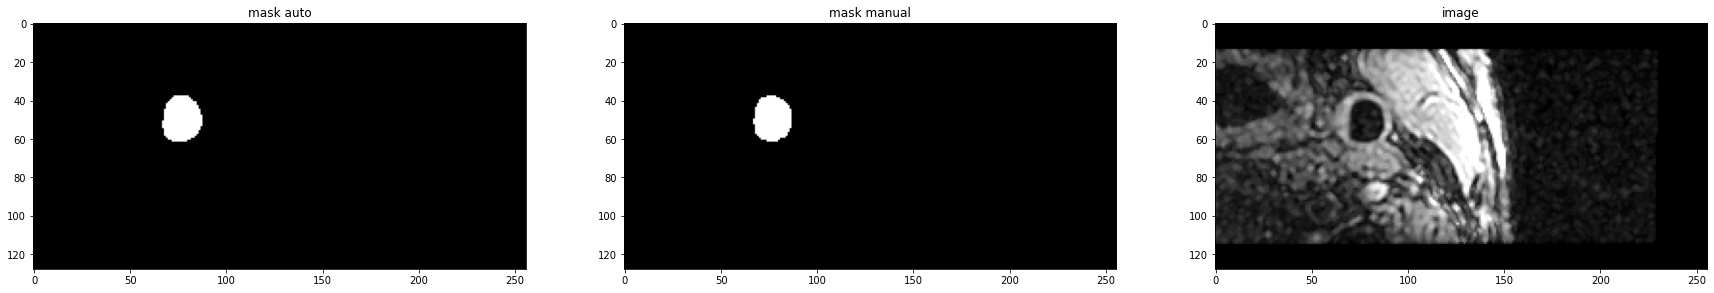

In [ ]:
# Plot:
random_index = random.randint(0, len(Y_val_right))
# random_index=209
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(Mask_auto_train_left[random_index][:,:,1],cmap=plt.cm.gray), ax1.set_title('mask auto')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(Y_train_left[random_index][:,:,1],cmap=plt.cm.gray), ax2.set_title('mask manual')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(X_train_3D_left[random_index][:,:,1],cmap=plt.cm.gray), ax3.set_title('image')

# Saving automatic masks

## Calcolo Centroidi di riferimento: Validation

* Validation Left

In [ ]:
# Calcolo centoidi per validation left
cont_pz=0
cont_slice_pz=0
flag=False
centroidi_val_left=np.zeros((len(num_slice_pz_valid_left),6),dtype=np.int16)
for slice_, n_slice , name in zip(Mask_auto_val_left[:,:,:,1],range(len(Mask_auto_val_left[:,:,:,1])),listOfimg_val_l):
  if(cont_pz<len(num_slice_pz_valid_left) and cont_slice_pz<num_slice_pz_valid_left[cont_pz]-1):
    cont_slice_pz+=1
    avail_slice_pre=name.split('I')[1]
    avail_slice=int(avail_slice_pre.split('.')[0])

    if avail_slice<400:       # cerco i centroidi solo dopo la zona della comune (voglio trovare slices con 2 vasi segmentati)
      contours,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    # calcolo contorni dei lumen segmentati
      if len(contours)==2 and flag==False:      # prendo come riferimento la prima slice dove trovo due contorni
          M_1 = cv2.moments(contours[0])
          M_2 = cv2.moments(contours[1])
          if M_1['m10']!=0 and M_1['m00']!=0 and M_1['m01']!=0 and M_2['m10']!=0 and M_2['m00']!=0 and M_2['m01']!=0:
            cx_1 = int(M_1['m10']/M_1['m00'])
            cy_1 = int(M_1['m01']/M_1['m00']) 
            cx_2 = int(M_2['m10']/M_2['m00'])
            cy_2 = int(M_2['m01']/M_2['m00'])
            if cy_1!=cy_2:
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(y==np.amin(y))
              ind_i=np.where(y==np.amax(y))
              centroidi_val_left[cont_pz][0]=x[ind_e[0]]
              centroidi_val_left[cont_pz][1]=y[ind_e[0]]
              centroidi_val_left[cont_pz][2]=x[ind_i[0]]
              centroidi_val_left[cont_pz][3]=y[ind_i[0]]
              centroidi_val_left[cont_pz][4]=cont_slice_pz
              centroidi_val_left[cont_pz][5]=cont_pz
              flag=True
            elif cy_1==cy_2 : 
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(x==np.amin(x))
              ind_i=np.where(x==np.amax(x))
              centroidi_val_left[cont_pz][0]=x[ind_e[0]]
              centroidi_val_left[cont_pz][1]=y[ind_e[0]]
              centroidi_val_left[cont_pz][2]=x[ind_i[0]]
              centroidi_val_left[cont_pz][3]=y[ind_i[0]]
              centroidi_val_left[cont_pz][4]=cont_slice_pz
              centroidi_val_left[cont_pz][5]=cont_pz
              flag=True
            
  else:
      cont_pz+=1
      cont_slice_pz=0 
      flag=False

* Validation Right

In [ ]:
# Calcolo centoidi per validation right
cont_pz=0
cont_slice_pz=0
cont=0
flag=False
centroidi_val_right=np.zeros((len(num_slice_pz_valid_right),6),dtype=np.int16)
for slice_, n_slice , name in zip(Mask_auto_val_right[:,:,:,1],range(len(Mask_auto_val_right[:,:,:,1])),listOfimg_val_r):
  if(cont_pz<len(num_slice_pz_valid_right) and cont_slice_pz<num_slice_pz_valid_right[cont_pz]-1):
    cont_slice_pz+=1
    avail_slice_pre=name.split('I')[1]
    avail_slice=int(avail_slice_pre.split('.')[0])
    if avail_slice<400:
      contours,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours)==2 and flag==False:
          M_1 = cv2.moments(contours[0])
          M_2 = cv2.moments(contours[1])
          if M_1['m10']!=0 and M_1['m00']!=0 and M_1['m01']!=0 and M_2['m10']!=0 and M_2['m00']!=0 and M_2['m01']!=0:
            cx_1 = int(M_1['m10']/M_1['m00'])
            cy_1 = int(M_1['m01']/M_1['m00']) 
            cx_2 = int(M_2['m10']/M_2['m00'])
            cy_2 = int(M_2['m01']/M_2['m00'])
            if cy_1!=cy_2: 
              cont+=1
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(y==np.amin(y))
              ind_i=np.where(y==np.amax(y))
              centroidi_val_right[cont_pz][0]=x[ind_e[0]]
              centroidi_val_right[cont_pz][1]=y[ind_e[0]]
              centroidi_val_right[cont_pz][2]=x[ind_i[0]]
              centroidi_val_right[cont_pz][3]=y[ind_i[0]]
              centroidi_val_right[cont_pz][4]=cont_slice_pz
              centroidi_val_right[cont_pz][5]=cont_pz
              flag=True
            elif cy_1==cy_2 : 
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(x==np.amin(x))
              ind_i=np.where(x==np.amax(x))
              centroidi_val_right[cont_pz][0]=x[ind_e[0]]
              centroidi_val_right[cont_pz][1]=y[ind_e[0]]
              centroidi_val_right[cont_pz][2]=x[ind_i[0]]
              centroidi_val_right[cont_pz][3]=y[ind_i[0]]
              centroidi_val_right[cont_pz][4]=cont_slice_pz
              centroidi_val_right[cont_pz][5]=cont_pz
              flag=True
            
  else:
      cont_pz+=1
      cont_slice_pz=0 
      flag=False



## Divisione maschere in ICA ed ECA

* Validation Left

In [ ]:
Mask_wall_ICAL_val_left=np.zeros_like(Mask_auto_val_left[:,:,:,0]) 
Mask_wall_ECAL_val_left=np.zeros_like(Mask_auto_val_left[:,:,:,0]) 
Mask_lume_ICAL_val_left=np.zeros_like(Mask_auto_val_left[:,:,:,0]) 
Mask_lume_ECAL_val_left=np.zeros_like(Mask_auto_val_left[:,:,:,0]) 
cont_pz=0
cont=0
cont_slice_pz=0
cont_lume_ECAL=0
cont_lume_ICAL=0
cont_wall_ECAL=0
cont_wall_ICAL=0
strel_dil = morphology.square(2)


* Calcolo centroidi di ogni slice (per paziente) per confrontarli con quelli di riferimento:

In [ ]:

for slice_, n_slice, name in zip(Mask_auto_val_left[:,:,:,1],range(len(Mask_auto_val_left[:,:,:,1])), listOfimg_val_l):
  flag_ECAL=False
  flag_ICAL=False
  avail_slice_pre=name.split('I')[1]
  avail_slice=int(avail_slice_pre.split('.')[0])     #indica il numero (profondità z) della slice [es: 350]  
  if np.any(slice_):         # entro solo se l'img non è tutta nera
    if(cont_pz<len(num_slice_pz_valid_left) and cont_slice_pz<num_slice_pz_valid_left[cont_pz]):
      cont_slice_pz+=1
      if centroidi_val_left[cont_pz][0]!=0 and avail_slice<400:        # se sono nella zona delle 'comuni' le metto a ICA
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)     # cerco contorni lume delle segmentazioni
        M_1 = cv2.moments(contours_lume[0])
        try:
          cx_1 = int(M_1['m10']/M_1['m00'])
          cy_1 = int(M_1['m01']/M_1['m00'])
          
          redrawed_mask_lume=np.zeros_like(slice_)   
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)  #se l'img non è nera, almeno 1 contorno di un lume lo trovo sempre
          # gestico il caso in cui mi trovo nella stessa slice dove ho trovato il riferimento:
          if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))==0:
            Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]]))==0:
            Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
          # assegno ilvaso a ICA o ECA, in base alla distanza euclidea dai centroidi di riferimento
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
          #elif abs(cx_1-centroidi_val[cont_pz][0])<abs(cx_1-centroidi_val[cont_pz][2]):
            Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
          #elif abs(cx_1-centroidi_val[cont_pz][0])>abs(cx_1-centroidi_val[cont_pz][2]):
            Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
              
          # calcolo contorni wall:
          contours_wall,_= cv2.findContours(Mask_auto_val_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          # se viene trovato più di un contorno del wall:
          if len(contours_wall)>1:
            wall_mask_1=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            if redrawed_mask_wall_0[cy_1][cx_1]==0:    #vedo se il centro della maschera ridisegnata è nero
              wall_mask_1= redrawed_mask_wall_0        #se è nero, la maschere ridisegnata da drawCountours ha forma 'a ciambella'
            else:
              # drawContours restituisce due maschere piene se il contorno di partenza è chiuso:
              wall_mask_1= np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1) 
              wall_mask_1=morphology.dilation(wall_mask_1,strel_dil)   # lieve dilatazione perchè drawContours prende i contorni interni
            if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))==0:
              Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]]))==0:  
              Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
            #elif abs(cx_1-centroidi_val[cont_pz][0])<abs(cx_1-centroidi_val[cont_pz][2]):
              Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
            #elif abs(cx_1-centroidi_val[cont_pz][0])>abs(cx_1-centroidi_val[cont_pz][2]):
              Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1

          # se il contorno trovato del wall è solo uno: 
          elif len(contours_wall)==1:
            if np.any(contours_wall):
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))==0:
                Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]]))==0:
                Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
              #elif abs(cx_1-centroidi_val[cont_pz][0])<abs(cx_1-centroidi_val[cont_pz][2]):
                Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
              #elif abs(cx_1-centroidi_val[cont_pz][0])>abs(cx_1-centroidi_val[cont_pz][2]):
                Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1

          # se c'è più di un lume segmentato:
          if len(contours_lume)>1 and len(contours_wall)>=2: 
            # se ho più di 2 lume segmentati:
            if len(contours_lume)==3:
              redrawed_mask_lume_1=np.zeros_like(slice_)
              redrawed_mask_lume_2=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              cv2.drawContours(redrawed_mask_lume_2,[contours_lume[2]],-1,255,-1)
              # controllo qual'è il lume maggiore:
              if np.sum(redrawed_mask_lume_2)>np.sum(redrawed_mask_lume_1):
                redrawed_mask_lume_1=redrawed_mask_lume_2
                M_2 = cv2.moments(contours_lume[2])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
              else:
                M_2 = cv2.moments(contours_lume[1])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
                redrawed_mask_lume_1=np.zeros_like(slice_)
                cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            # se ho due lume segmentati:
            elif len(contours_lume)==2:
              M_2 = cv2.moments(contours_lume[1])
              cx_2 = int(M_2['m10']/M_2['m00'])
              cy_2 = int(M_2['m01']/M_2['m00'])
              redrawed_mask_lume_1=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            
            wall_mask_2=np.zeros_like(slice_)
          # se ho 2 contorni del wall:
            if len(contours_wall)==2:
              # controllo se il wall è 'a ciambella'
              if redrawed_mask_wall_1[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_1
            redrawed_mask_wall_2=np.zeros_like(slice_)
            redrawed_mask_wall_3=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              # se ho 3 contorni del wall:
            if len(contours_wall)==3:
              if redrawed_mask_wall_2[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_2
              else:
                wall_mask_2= np.logical_xor(redrawed_mask_wall_1,redrawed_mask_wall_2)
                wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
                # se ho 4 contorni del wall:
            if len(contours_wall)==4:  
              cv2.drawContours(redrawed_mask_wall_3,[contours_wall[3]],-1,255,-1)
              wall_mask_2= np.logical_xor(redrawed_mask_wall_2,redrawed_mask_wall_3)
              wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            
            if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))==0:
              Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_2
              cont_lume_ECAL+=1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]]))==0:
              Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_2
              cont_lume_ICAL+=1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
            #elif abs(cx_2-centroidi_val[cont_pz][0])<abs(cx_2-centroidi_val[cont_pz][2]):
            # controllo se ho già trovato una ECAL: (non voglio assegnare due vasi alla stessa classe), potrebbe capitare che per entrambi i vasi
            # sono posizionati più vicini ad un interna o esterna
             if flag_ECAL==False:   
                cont+=1
                Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_2
                cont_lume_ECAL+=1
                cont_wall_ECAL+=1
             else:
               # scelgo il vaso con la distanza inferiore da assegnare ad ECA:
              if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]])):
                Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_2
                Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
              elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]])):
                Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_1
                Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_2

            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][1],centroidi_val_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
            #elif abs(cx_2-centroidi_val[cont_pz][0])>abs(cx_2-centroidi_val[cont_pz][2]):
              if flag_ICAL==False: 
                Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_2
                cont_lume_ICAL+=1
                cont_wall_ICAL+=1
              else:
                if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
                  Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_2
                  Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_1
                elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_left[cont_pz][3],centroidi_val_left[cont_pz][2]])):
                  Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
                  Mask_lume_ECAL_val_left[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ECAL_val_left[n_slice,:,:]=wall_mask_2
        
        # se non trovo centroidi: assegno ad ICA
        except:
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
          Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume
          cont_lume_ICAL+=1
          cont+=1
          contours_wall,_= cv2.findContours(Mask_auto_val_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours_wall)>1:
            wall_mask_2=np.zeros_like(slice_)
            redrawed_mask_wall_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
            wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_2
            cont_wall_ICAL+=1
          else: 
            if np.any(contours_wall):
              wall_mask_1=np.zeros_like(slice_) 
              redrawed_mask_wall_0=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
      else:
        # se mi trovo nella zona della comune oppure non ho trovato i centroidi di  riferimento per quel paziente 
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        redrawed_mask_lume=np.zeros_like(slice_)
        cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
        Mask_lume_ICAL_val_left[n_slice,:,:]=redrawed_mask_lume
        cont_lume_ICAL+=1
        
        contours_wall,_= cv2.findContours(Mask_auto_val_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_wall)>1:
          wall_mask_2=np.zeros_like(slice_)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
          cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
          wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
          wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
          Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_2
          cont_wall_ICAL+=1
        else:
          if np.any(contours_wall):  
            wall_mask_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            wall_mask_1=redrawed_mask_wall_0
            Mask_wall_ICAL_val_left[n_slice,:,:]=wall_mask_1
            cont_wall_ICAL+=1
 
    else:
      # aggiorno contatore del paziente per processare quello successivo:
      cont_pz+=1
      cont_slice_pz=0 

* Validation Right


In [ ]:
Mask_wall_ICAR_val_right=np.zeros_like(Mask_auto_val_right[:,:,:,0]) 
Mask_wall_ECAR_val_right=np.zeros_like(Mask_auto_val_right[:,:,:,0]) 
Mask_lume_ICAR_val_right=np.zeros_like(Mask_auto_val_right[:,:,:,0]) 
Mask_lume_ECAR_val_right=np.zeros_like(Mask_auto_val_right[:,:,:,0]) 
cont_pz=0
cont=0
cont_slice_pz=0
cont_lume_ECAL=0
cont_lume_ICAL=0
cont_wall_ECAL=0
cont_wall_ICAL=0
strel_dil = morphology.square(2)

In [ ]:
for slice_, n_slice, name in zip(Mask_auto_val_right[:,:,:,1],range(len(Mask_auto_val_right[:,:,:,1])),listOfimg_val_r):
  flag_ECAL=False
  flag_ICAL=False
  avail_slice_pre=name.split('I')[1]
  avail_slice=int(avail_slice_pre.split('.')[0])
  if np.any(slice_): 
    if(cont_pz<len(num_slice_pz_valid_right) and cont_slice_pz<num_slice_pz_valid_right[cont_pz]):
      cont_slice_pz+=1
      if centroidi_val_right[cont_pz][0]!=0 and avail_slice<400:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        M_1 = cv2.moments(contours_lume[0])
        try:
          cx_1 = int(M_1['m10']/M_1['m00'])
          cy_1 = int(M_1['m01']/M_1['m00'])
          
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)

          if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))==0:
            Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]]))==0:
            Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
          #elif abs(cx_1-centroidi_val[cont_pz][0])<abs(cx_1-centroidi_val[cont_pz][2]):
            Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
          #elif abs(cx_1-centroidi_val[cont_pz][0])>abs(cx_1-centroidi_val[cont_pz][2]):
            Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
              
          
          contours_wall,_= cv2.findContours(Mask_auto_val_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)

          if len(contours_wall)>1:
            wall_mask_1=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            if redrawed_mask_wall_0[cy_1][cx_1]==0:
              wall_mask_1= redrawed_mask_wall_0
            else:
              wall_mask_1= np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
              wall_mask_1=morphology.dilation(wall_mask_1,strel_dil)
            if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))==0:
              Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]]))==0:  
              Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
            #elif abs(cx_1-centroidi_val[cont_pz][0])<abs(cx_1-centroidi_val[cont_pz][2]):
              Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
            #elif abs(cx_1-centroidi_val[cont_pz][0])>abs(cx_1-centroidi_val[cont_pz][2]):
              Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1

          elif len(contours_wall)==1:
            if np.any(contours_wall):
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))==0:
                Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]]))==0:
                Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
              #elif abs(cx_1-centroidi_val[cont_pz][0])<abs(cx_1-centroidi_val[cont_pz][2]):
                Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_lright[cont_pz][2]])):
              #elif abs(cx_1-centroidi_val[cont_pz][0])>abs(cx_1-centroidi_val[cont_pz][2]):
                Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1

          if len(contours_lume)>1 and len(contours_wall)>=2:
            if len(contours_lume)==3:
              redrawed_mask_lume_1=np.zeros_like(slice_)
              redrawed_mask_lume_2=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              cv2.drawContours(redrawed_mask_lume_2,[contours_lume[2]],-1,255,-1)
              if np.sum(redrawed_mask_lume_2)>np.sum(redrawed_mask_lume_1):
                redrawed_mask_lume_1=redrawed_mask_lume_2
                M_2 = cv2.moments(contours_lume[2])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
              else:
                M_2 = cv2.moments(contours_lume[1])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
                redrawed_mask_lume_1=np.zeros_like(slice_)
                cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            elif len(contours_lume)==2:
              M_2 = cv2.moments(contours_lume[1])
              cx_2 = int(M_2['m10']/M_2['m00'])
              cy_2 = int(M_2['m01']/M_2['m00'])
              redrawed_mask_lume_1=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              
            
            wall_mask_2=np.zeros_like(slice_)
          
            if len(contours_wall)==2:
              if redrawed_mask_wall_1[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_1
            redrawed_mask_wall_2=np.zeros_like(slice_)
            redrawed_mask_wall_3=np.zeros_like(slice_)
            
            if len(contours_wall)==3:
              cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              if redrawed_mask_wall_2[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_2
              else:
                wall_mask_2= np.logical_xor(redrawed_mask_wall_1,redrawed_mask_wall_2)
                wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            if len(contours_wall)==4:  
              cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              cv2.drawContours(redrawed_mask_wall_3,[contours_wall[3]],-1,255,-1)
              wall_mask_2= np.logical_xor(redrawed_mask_wall_2,redrawed_mask_wall_3)
              wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            
            if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))==0:
              Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_2
              cont_lume_ECAL+=1
              cont_wall_ECAL+=1
              if n_slice==163:
                  print('i')
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]]))==0:
              Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_2
              cont_lume_ICAL+=1
              cont_wall_ICAL+=1
              if n_slice==163:
                  print('i_2')
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
            #elif abs(cx_2-centroidi_val[cont_pz][0])<abs(cx_2-centroidi_val[cont_pz][2]):
             if flag_ECAL==False:   
                cont+=1
                Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_2
                cont_lume_ECAL+=1
                cont_wall_ECAL+=1
                
             else:
              if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]])):
                Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_2
                Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
                
              elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]])):
                Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_1
                Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_2
                

            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][1],centroidi_val_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
            #elif abs(cx_2-centroidi_val[cont_pz][0])>abs(cx_2-centroidi_val[cont_pz][2]):
              if flag_ICAL==False: 
                Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_2
                cont_lume_ICAL+=1
                cont_wall_ICAL+=1
                
              else:
                if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
                  Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_2
                  Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_1
                  
                elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_val_right[cont_pz][3],centroidi_val_right[cont_pz][2]])):
                  Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
                  Mask_lume_ECAR_val_right[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ECAR_val_right[n_slice,:,:]=wall_mask_2
                  

        except:
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
          Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume
          cont_lume_ICAL+=1
          cont+=1
          contours_wall,_= cv2.findContours(Mask_auto_val_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours_wall)>1:
            wall_mask_2=np.zeros_like(slice_)
            redrawed_mask_wall_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
            wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_2
            cont_wall_ICAL+=1
          else: 
            if np.any(contours_wall):
              wall_mask_1=np.zeros_like(slice_) 
              redrawed_mask_wall_0=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
      else:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        redrawed_mask_lume=np.zeros_like(slice_)
        cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
        Mask_lume_ICAR_val_right[n_slice,:,:]=redrawed_mask_lume
        cont_lume_ICAL+=1
        
        contours_wall,_= cv2.findContours(Mask_auto_val_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_wall)>1:
          wall_mask_2=np.zeros_like(slice_)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
          cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
          wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
          wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
          Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_2
          cont_wall_ICAL+=1
        else:
          if np.any(contours_wall):  
            wall_mask_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            wall_mask_1=redrawed_mask_wall_0
            Mask_wall_ICAR_val_right[n_slice,:,:]=wall_mask_1
            cont_wall_ICAL+=1
        
    else:
      cont_pz+=1
      cont_slice_pz=0
      

## Calcolo Centroidi di riferimento: Training

Train Left

In [ ]:
# Calcolo centoidi per train left
cont_pz=0
cont_slice_pz=0
flag=False
centroidi_train_left=np.zeros((len(num_slice_pz_train_left),6),dtype=np.int16)
for slice_, n_slice , name in zip(Mask_auto_train_left[:,:,:,1],range(len(Mask_auto_train_left[:,:,:,1])),listOfimg_train_l):
  if(cont_pz<len(num_slice_pz_train_left) and cont_slice_pz<num_slice_pz_train_left[cont_pz]-1):
    cont_slice_pz+=1
    avail_slice_pre=name.split('I')[1]
    avail_slice=int(avail_slice_pre.split('.')[0])
    if avail_slice<400:
      contours,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours)==2 and flag==False:
          M_1 = cv2.moments(contours[0])
          M_2 = cv2.moments(contours[1])
          if M_1['m10']!=0 and M_1['m00']!=0 and M_1['m01']!=0 and M_2['m10']!=0 and M_2['m00']!=0 and M_2['m01']!=0:
            cx_1 = int(M_1['m10']/M_1['m00'])
            cy_1 = int(M_1['m01']/M_1['m00']) 
            cx_2 = int(M_2['m10']/M_2['m00'])
            cy_2 = int(M_2['m01']/M_2['m00'])
            if cy_1!=cy_2 : #and cont_slice_contour==2:
              cont+=1
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(y==np.amin(y))
              ind_i=np.where(y==np.amax(y))
              centroidi_train_left[cont_pz][0]=x[ind_e[0]]
              centroidi_train_left[cont_pz][1]=y[ind_e[0]]
              centroidi_train_left[cont_pz][2]=x[ind_i[0]]
              centroidi_train_left[cont_pz][3]=y[ind_i[0]]
              centroidi_train_left[cont_pz][4]=cont_slice_pz
              centroidi_train_left[cont_pz][5]=cont_pz
              flag=True
            elif cy_1==cy_2 : 
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(x==np.amin(x))
              ind_i=np.where(x==np.amax(x))
              centroidi_train_left[cont_pz][0]=x[ind_e[0]]
              centroidi_train_left[cont_pz][1]=y[ind_e[0]]
              centroidi_train_left[cont_pz][2]=x[ind_i[0]]
              centroidi_train_left[cont_pz][3]=y[ind_i[0]]
              centroidi_train_left[cont_pz][4]=cont_slice_pz
              centroidi_train_left[cont_pz][5]=cont_pz
            
  else:
      cont_pz+=1
      cont_slice_pz=0 

Train Right

In [ ]:
# Calcolo centoidi per train right
cont_pz=0
cont_slice_pz=0
flag=False
centroidi_train_right=np.zeros((len(num_slice_pz_train_right),6),dtype=np.int16)
for slice_, n_slice , name in zip(Mask_auto_train_right[:,:,:,1],range(len(Mask_auto_train_right[:,:,:,1])),listOfimg_train_r):
  if(cont_pz<len(num_slice_pz_train_right) and cont_slice_pz<num_slice_pz_train_right[cont_pz]-1):
    cont_slice_pz+=1
    avail_slice_pre=name.split('I')[1]
    avail_slice=int(avail_slice_pre.split('.')[0])
    if avail_slice<400:
      contours,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours)==2 and flag==False:
          M_1 = cv2.moments(contours[0])
          M_2 = cv2.moments(contours[1])
          if M_1['m10']!=0 and M_1['m00']!=0 and M_1['m01']!=0 and M_2['m10']!=0 and M_2['m00']!=0 and M_2['m01']!=0:
            cx_1 = int(M_1['m10']/M_1['m00'])
            cy_1 = int(M_1['m01']/M_1['m00']) 
            cx_2 = int(M_2['m10']/M_2['m00'])
            cy_2 = int(M_2['m01']/M_2['m00'])
            if cy_1!=cy_2:
              cont+=1
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(y==np.amin(y))
              ind_i=np.where(y==np.amax(y))
              centroidi_train_right[cont_pz][0]=x[ind_e[0]]
              centroidi_train_right[cont_pz][1]=y[ind_e[0]]
              centroidi_train_right[cont_pz][2]=x[ind_i[0]]
              centroidi_train_right[cont_pz][3]=y[ind_i[0]]
              centroidi_train_right[cont_pz][4]=cont_slice_pz
              centroidi_train_right[cont_pz][5]=cont_pz
              flag=True
            elif cy_1==cy_2 : 
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(x==np.amin(x))
              ind_i=np.where(x==np.amax(x))
              centroidi_train_right[cont_pz][0]=x[ind_e[0]]
              centroidi_train_right[cont_pz][1]=y[ind_e[0]]
              centroidi_train_right[cont_pz][2]=x[ind_i[0]]
              centroidi_train_right[cont_pz][3]=y[ind_i[0]]
              centroidi_train_right[cont_pz][4]=cont_slice_pz
              centroidi_train_right[cont_pz][5]=cont_pz
              flag=True
  else:
      cont_pz+=1
      cont_slice_pz=0 
      flag=False

## Divisione maschere in ICA ed ECA


Train Left

In [ ]:
Mask_wall_ICAL_train_left=np.zeros_like(Mask_auto_train_left[:,:,:,0]) 
Mask_wall_ECAL_train_left=np.zeros_like(Mask_auto_train_left[:,:,:,0]) 
Mask_lume_ICAL_train_left=np.zeros_like(Mask_auto_train_left[:,:,:,0]) 
Mask_lume_ECAL_train_left=np.zeros_like(Mask_auto_train_left[:,:,:,0]) 
cont_pz=0
cont=0
cont_slice_pz=0
cont_lume_ECAL=0
cont_lume_ICAL=0
cont_wall_ECAL=0
cont_wall_ICAL=0
strel_dil = morphology.square(2)


In [ ]:
for slice_, n_slice, name in zip(Mask_auto_train_left[:,:,:,1],range(len(Mask_auto_train_left[:,:,:,1])),listOfimg_train_l):
  flag_ECAL=False
  flag_ICAL=False
  avail_slice_pre=name.split('I')[1]
  avail_slice=int(avail_slice_pre.split('.')[0])
  if np.any(slice_): 
    if(cont_pz<len(num_slice_pz_train_left) and cont_slice_pz<num_slice_pz_train_left[cont_pz]):
      cont_slice_pz+=1
      if centroidi_train_left[cont_pz][0]!=0 and avail_slice<400:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        M_1 = cv2.moments(contours_lume[0])
        try:
          cx_1 = int(M_1['m10']/M_1['m00'])
          cy_1 = int(M_1['m01']/M_1['m00'])
          
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)

          if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))==0:
            Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]]))==0:
            Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])): 
            Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
            Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
              
          
          contours_wall,_= cv2.findContours(Mask_auto_train_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)

          if len(contours_wall)>1:
            wall_mask_1=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            if redrawed_mask_wall_0[cy_1][cx_1]==0:
              wall_mask_1= redrawed_mask_wall_0
            else:
              wall_mask_1= np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
              wall_mask_1=morphology.dilation(wall_mask_1,strel_dil)
            if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))==0:
              Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]]))==0:  
              Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])): 
              Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):  
              Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1

          elif len(contours_wall)==1:
            if np.any(contours_wall):
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))==0:
                Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]]))==0:
                Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
                Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
                Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1

          if len(contours_lume)>1 and len(contours_wall)>=2: 
            if len(contours_lume)==3:
              redrawed_mask_lume_1=np.zeros_like(slice_)
              redrawed_mask_lume_2=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              cv2.drawContours(redrawed_mask_lume_2,[contours_lume[2]],-1,255,-1)
              if np.sum(redrawed_mask_lume_2)>np.sum(redrawed_mask_lume_1):
                redrawed_mask_lume_1=redrawed_mask_lume_2
                M_2 = cv2.moments(contours_lume[2])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
              else:
                M_2 = cv2.moments(contours_lume[1])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
                redrawed_mask_lume_1=np.zeros_like(slice_)
                cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            elif len(contours_lume)==2:
              M_2 = cv2.moments(contours_lume[1])
              cx_2 = int(M_2['m10']/M_2['m00'])
              cy_2 = int(M_2['m01']/M_2['m00'])
              redrawed_mask_lume_1=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              if n_slice==32:
                  print('eccolo') 
            
            wall_mask_2=np.zeros_like(slice_)
          
            if len(contours_wall)==2:
              if redrawed_mask_wall_1[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_1
            redrawed_mask_wall_2=np.zeros_like(slice_)
            redrawed_mask_wall_3=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
            if len(contours_wall)==3:
              if redrawed_mask_wall_2[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_2
              else:
                wall_mask_2= np.logical_xor(redrawed_mask_wall_1,redrawed_mask_wall_2)
                wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            if len(contours_wall)==4:  
              cv2.drawContours(redrawed_mask_wall_3,[contours_wall[3]],-1,255,-1)
              wall_mask_2= np.logical_xor(redrawed_mask_wall_2,redrawed_mask_wall_3)
              wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            
            if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))==0:
              Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_2
              cont_lume_ECAL+=1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]]))==0:
              Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_2
              cont_lume_ICAL+=1
              cont_wall_ICAL+=1
            #elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
            #elif abs(cx_2-centroidi_train[cont_pz][0])<abs(cx_2-centroidi_train[cont_pz][2]):
            elif abs(cy_2-centroidi_train_left[cont_pz][1])<abs(cy_2-centroidi_train_left[cont_pz][3]):  
             if flag_ECAL==False:   
                cont+=1
                Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_2
                cont_lume_ECAL+=1
                cont_wall_ECAL+=1
             else:
              if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]])):
                Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_2
                Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
              elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]])):
                Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_1
                Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_2

            #elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][1],centroidi_train_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
            #elif abs(cx_2-centroidi_train[cont_pz][0])>abs(cx_2-centroidi_train[cont_pz][2]):
            elif abs(cy_2-centroidi_train_left[cont_pz][1])>abs(cy_2-centroidi_train_left[cont_pz][3]): 
              if flag_ICAL==False: 
                Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_2
                cont_lume_ICAL+=1
                cont_wall_ICAL+=1
              else:
                if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
                  Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_2
                  Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_1
                elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_left[cont_pz][3],centroidi_train_left[cont_pz][2]])):
                  Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
                  Mask_lume_ECAL_train_left[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ECAL_train_left[n_slice,:,:]=wall_mask_2

        except:
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
          Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume
          cont_lume_ICAL+=1
          cont+=1
          contours_wall,_= cv2.findContours(Mask_auto_train_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours_wall)>1:
            wall_mask_2=np.zeros_like(slice_)
            redrawed_mask_wall_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
            wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_2
            cont_wall_ICAL+=1
          else: 
            if np.any(contours_wall):
              wall_mask_1=np.zeros_like(slice_) 
              redrawed_mask_wall_0=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
      else:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        redrawed_mask_lume=np.zeros_like(slice_)
        cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
        Mask_lume_ICAL_train_left[n_slice,:,:]=redrawed_mask_lume
        cont_lume_ICAL+=1
        
        contours_wall,_= cv2.findContours(Mask_auto_train_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_wall)>1:
          wall_mask_2=np.zeros_like(slice_)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
          cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
          wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
          wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
          Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_2
          cont_wall_ICAL+=1
        else:
          if np.any(contours_wall):  
            wall_mask_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            wall_mask_1=redrawed_mask_wall_0
            Mask_wall_ICAL_train_left[n_slice,:,:]=wall_mask_1
            cont_wall_ICAL+=1
 
    else:
      cont_pz+=1
      cont_slice_pz=0 

Train Right

In [ ]:
Mask_wall_ICAR_train_right=np.zeros_like(Mask_auto_train_right[:,:,:,0]) 
Mask_wall_ECAR_train_right=np.zeros_like(Mask_auto_train_right[:,:,:,0]) 
Mask_lume_ICAR_train_right=np.zeros_like(Mask_auto_train_right[:,:,:,0]) 
Mask_lume_ECAR_train_right=np.zeros_like(Mask_auto_train_right[:,:,:,0]) 
cont_pz=0
cont=0
cont_slice_pz=0
cont_lume_ECAR=0
cont_lume_ICAR=0
cont_wall_ECAR=0
cont_wall_ICAR=0
strel_dil = morphology.square(2)

In [ ]:
for slice_, n_slice, name in zip(Mask_auto_train_right[:,:,:,1],range(len(Mask_auto_train_right[:,:,:,1])),listOfimg_train_r):
  flag_ECAR=False
  flag_ICAR=False
  cont_slice_pz+=1
  avail_slice_pre=name.split('I')[1]
  avail_slice=int(avail_slice_pre.split('.')[0])
  if np.any(slice_): 
    if(cont_pz<len(num_slice_pz_train_right) and cont_slice_pz<num_slice_pz_train_right[cont_pz]):
      cont_slice_pz+=1
      if centroidi_train_right[cont_pz][0]!=0 and avail_slice<400:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        M_1 = cv2.moments(contours_lume[0])
        try:
          cx_1 = int(M_1['m10']/M_1['m00'])
          cy_1 = int(M_1['m01']/M_1['m00'])
          
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)

          if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))==0:
            Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAR+=1
            flag_ECAR=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]]))==0:
            Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAR+=1
            flag_ICAR=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
          #elif abs(cx_1-centroidi_train[cont_pz][0])<abs(cx_1-centroidi_train[cont_pz][2]):
            Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAR+=1
            flag_ECAR=True

          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
          #elif abs(cx_1-centroidi_train[cont_pz][0])>abs(cx_1-centroidi_train[cont_pz][2])
            Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAR+=1
            flag_ICAR=True
              
          
          contours_wall,_= cv2.findContours(Mask_auto_train_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)

          if len(contours_wall)>1:
            wall_mask_1=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            if redrawed_mask_wall_0[cy_1][cx_1]==0:
              wall_mask_1= redrawed_mask_wall_0
            else:
              wall_mask_1= np.logICAR_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
              wall_mask_1=morphology.dilation(wall_mask_1,strel_dil)
            if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))==0:
              Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_1
              cont_wall_ECAR+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]]))==0:  
              Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAR+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
            #elif abs(cx_1-centroidi_train[cont_pz][0])<abs(cx_1-centroidi_train[cont_pz][2]):
              Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_1
              cont_wall_ECAR+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
            #elif abs(cx_1-centroidi_train[cont_pz][0])>abs(cx_1-centroidi_train[cont_pz][2]):
              Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAR+=1

          elif len(contours_wall)==1:
            if np.any(contours_wall):
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))==0:
                Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_1
                cont_wall_ECAR+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]]))==0:
                Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
                cont_wall_ICAR+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
              #elif abs(cx_1-centroidi_train[cont_pz][0])<abs(cx_1-centroidi_train[cont_pz][2]):
                Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_1
                cont_wall_ECAR+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_lright[cont_pz][2]])):
              #elif abs(cx_1-centroidi_train[cont_pz][0])>abs(cx_1-centroidi_train[cont_pz][2]):
                Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
                cont_wall_ICAR+=1

          if len(contours_lume)>1 and len(contours_wall)>=2:
            if len(contours_lume)==3:
              redrawed_mask_lume_1=np.zeros_like(slice_)
              redrawed_mask_lume_2=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              cv2.drawContours(redrawed_mask_lume_2,[contours_lume[2]],-1,255,-1)
              if np.sum(redrawed_mask_lume_2)>np.sum(redrawed_mask_lume_1):
                redrawed_mask_lume_1=redrawed_mask_lume_2
                M_2 = cv2.moments(contours_lume[2])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
              else:
                M_2 = cv2.moments(contours_lume[1])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
                redrawed_mask_lume_1=np.zeros_like(slice_)
                cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            elif len(contours_lume)==2:
              M_2 = cv2.moments(contours_lume[1])
              cx_2 = int(M_2['m10']/M_2['m00'])
              cy_2 = int(M_2['m01']/M_2['m00'])
              redrawed_mask_lume_1=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              
            
            wall_mask_2=np.zeros_like(slice_)
          
            if len(contours_wall)==2:
              if redrawed_mask_wall_1[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_1
            redrawed_mask_wall_2=np.zeros_like(slice_)
            redrawed_mask_wall_3=np.zeros_like(slice_)
            
            if len(contours_wall)==3:
              cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              if redrawed_mask_wall_2[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_2
              else:
                wall_mask_2= np.logical_xor(redrawed_mask_wall_1,redrawed_mask_wall_2)
                wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            if len(contours_wall)==4:  
              cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              cv2.drawContours(redrawed_mask_wall_3,[contours_wall[3]],-1,255,-1)
              wall_mask_2= np.logical_xor(redrawed_mask_wall_2,redrawed_mask_wall_3)
              wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            
            if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))==0:
              Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_2
              cont_lume_ECAR+=1
              cont_wall_ECAR+=1
              if n_slice==163:
                  print('i')
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]]))==0:
              Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_2
              cont_lume_ICAR+=1
              cont_wall_ICAR+=1
              if n_slice==163:
                  print('i_2')
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
            #elif abs(cx_2-centroidi_train[cont_pz][0])<abs(cx_2-centroidi_train[cont_pz][2]):
             if flag_ECAR==False:   
                cont+=1
                Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_2
                cont_lume_ECAR+=1
                cont_wall_ECAR+=1
                
             else:
              if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]])):
                Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_2
                Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
                
              elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]])):
                Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_1
                Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_2
                

            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][1],centroidi_train_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
            #elif abs(cx_2-centroidi_train[cont_pz][0])>abs(cx_2-centroidi_train[cont_pz][2]):
              if flag_ICAR==False: 
                Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_2
                cont_lume_ICAR+=1
                cont_wall_ICAR+=1
                
              else:
                if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
                  Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_2
                  Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_1
                  
                elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_train_right[cont_pz][3],centroidi_train_right[cont_pz][2]])):
                  Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
                  Mask_lume_ECAR_train_right[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ECAR_train_right[n_slice,:,:]=wall_mask_2
                  

        except:
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
          Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume
          cont_lume_ICAR+=1
          cont+=1
          contours_wall,_= cv2.findContours(Mask_auto_train_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours_wall)>1:
            wall_mask_2=np.zeros_like(slice_)
            redrawed_mask_wall_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
            wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_2
            cont_wall_ICAR+=1
          else: 
            if np.any(contours_wall):
              wall_mask_1=np.zeros_like(slice_) 
              redrawed_mask_wall_0=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAR+=1
      else:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        redrawed_mask_lume=np.zeros_like(slice_)
        cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
        Mask_lume_ICAR_train_right[n_slice,:,:]=redrawed_mask_lume
        cont_lume_ICAR+=1
        
        contours_wall,_= cv2.findContours(Mask_auto_train_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_wall)>1:
          wall_mask_2=np.zeros_like(slice_)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
          cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
          wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
          wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
          Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_2
          cont_wall_ICAR+=1
        else:
          if np.any(contours_wall):  
            wall_mask_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            wall_mask_1=redrawed_mask_wall_0
            Mask_wall_ICAR_train_right[n_slice,:,:]=wall_mask_1
            cont_wall_ICAR+=1
        
    else:
      cont_pz+=1
      cont_slice_pz=0 

## Ricostruzione Maschere

* Creazione cartelle dove salvare le maschere automatiche finali

In [ ]:
path = os.getcwd()
# Create 'New Data folder'
if not os.path.exists(os.path.join(path,data_type[1])):
    os.mkdir(os.path.join(path,data_type[1]))

for sett in set_type:
    if not os.path.exists(os.path.join(path,data_type[1],sett)):
        os.mkdir(os.path.join(path,data_type[1],sett))


newTrain_dir = os.path.join(path,data_type[1],set_type[0])
newVal_dir = os.path.join(path,data_type[1],set_type[1])

for pz in listOfPz_train_l:
    if not os.path.exists(os.path.join(newTrain_dir,pz)):
        os.mkdir(os.path.join(newTrain_dir,pz))

for pz in listOfPz_valid_l:
    if not os.path.exists(os.path.join(newVal_dir,pz)):
        os.mkdir(os.path.join(newVal_dir,pz))

* Train

In [ ]:
mask_empty=np.zeros_like(Mask_lume_ICAR_train_right[0,:,:],dtype=np.uint8)  # matrice vuota da concatenare a dx o sx per ricostruire l'immagine completa
final_mask=np.zeros((100,720),dtype=np.uint8)      # maschera completa
lateral=np.zeros((128,104),dtype=np.uint8)         # matrice da concatenare per riportare l'img alle dimensioni originali (passaggio inverso al crop eseguito in Preprocessing)

# ricostruisco maschere per salvataggio lume ICAR:
cont_pz=0
for slice_, n_slice , name_r in zip(Mask_lume_ICAR_train_right,range(len(Mask_lume_ICAR_train_right)),listOfimg_train_r):
 if num_slice_pz_train_right[cont_pz]!=0:   # controllo che il pz abbia almeno una slice
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):     # se la maschera non è vuota la salvo
        # ricostruzione maschera
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ICAR'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
 else:
   cont_pz+=1

# ricostruisco maschere per salvataggio lume ECAR:
cont_pz=0
for slice_, n_slice , name_r in zip(Mask_lume_ECAR_train_right,range(len(Mask_lume_ECAR_train_right)),listOfimg_train_r):
 if num_slice_pz_train_right[cont_pz]!=0:   
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ECAR'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
 else:
   cont_pz+=1

# ricostruisco maschere per salvataggio lume ICAL:
cont_pz=0
for slice_, n_slice , name_l in zip(Mask_lume_ICAL_train_left,range(len(Mask_lume_ICAL_train_left)),listOfimg_train_l):
 if num_slice_pz_train_left[cont_pz]!=0:    
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ICAL'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
 else:
   cont_pz+=1

# ricostruisco maschere per salvataggio lume ECAL:
cont_pz=0
for slice_, n_slice , name_l in zip(Mask_lume_ECAL_train_left,range(len(Mask_lume_ECAL_train_left)),listOfimg_train_l):
 if num_slice_pz_train_left[cont_pz]!=0:   
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if cont_pz<len(listOfPz_train_l) and np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ECAL'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
    
 else:
   cont_pz+=1

# ricostruisco maschere per salvataggio wall ICAR:
cont_pz=0
for slice_, n_slice , name_r in zip(Mask_wall_ICAR_train_right,range(len(Mask_wall_ICAR_train_right)),listOfimg_train_r):
  if num_slice_pz_train_right[cont_pz]!=0:
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ICAR'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else:
    cont_pz+=1

# ricostruisco maschere per salvataggio wall ECAR:
cont_pz=0
for slice_, n_slice , name_r in zip(Mask_wall_ECAR_train_right,range(len(Mask_wall_ECAR_train_right)),listOfimg_train_r):
  if num_slice_pz_train_right[cont_pz]!=0:  
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ECAR'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else:
    cont_pz+=1

# ricostruisco maschere per salvataggio wall ICAL:
cont_pz=0
for slice_, n_slice , name_l in zip(Mask_wall_ICAL_train_left,range(len(Mask_wall_ICAL_train_left)),listOfimg_train_l):
  if num_slice_pz_train_left[cont_pz]!=0:  
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ICAL'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else:
    cont_pz+=1  

# ricostruisco maschere per salvataggio wall ECAL:
cont_pz=0
for slice_, n_slice , name_l in zip(Mask_wall_ECAL_train_left,range(len(Mask_wall_ECAL_train_left)),listOfimg_train_l):
  if num_slice_pz_train_left[cont_pz]!=0:  
    pi = int(listOfPz_train_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if cont_pz<len(listOfPz_train_l) and np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newTrain_dir,listOfPz_train_l[cont_pz],name +'_ECAL'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else: 
    cont_pz+=1
    

D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:18: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Laboratori\Challenge\RESULTS_inception3\TRAIN\0_P2_U\EP2S101I498_ICAR_lume.png is a low contrast image
D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:18: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Laboratori\Challenge\RESULTS_inception3\TRAIN\0_P2_U\EP2S101I493_ICAR_lume.png is a low contrast image
D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:18: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Laboratori\Challenge\RESULTS_inception3\TRAIN\0_P2_U\EP2S101I488_ICAR_lume.png is a low contrast image
D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:18: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Lab

* Validation


In [ ]:

mask_empty=np.zeros_like(Mask_lume_ICAR_val_right[0,:,:],dtype=np.uint8)
final_mask=np.zeros((100,720),dtype=np.uint8)
lateral=np.zeros((128,104),dtype=np.uint8)
cont_pz=0

for slice_, n_slice , name_r in zip(Mask_lume_ICAR_val_right,range(len(Mask_lume_ICAR_val_right)),listOfimg_val_r):
 if num_slice_pz_valid_right[cont_pz]!=0:  
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ICAR'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
 else:
   cont_pz+=1

cont_pz=0

for slice_, n_slice , name_r in zip(Mask_lume_ECAR_val_right,range(len(Mask_lume_ECAR_val_right)),listOfimg_val_r):
 if num_slice_pz_valid_right[cont_pz]!=0:   
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ECAR'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
 else:
   cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_lume_ICAL_val_left,range(len(Mask_lume_ICAL_val_left)),listOfimg_val_l):
 if num_slice_pz_valid_left[cont_pz]!=0:    
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ICAL'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
 else:
   cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_lume_ECAL_val_left,range(len(Mask_lume_ECAL_val_left)),listOfimg_val_l):
 if num_slice_pz_valid_left[cont_pz]!=0:   
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ECAL'+'_'+'lume'+'.png'),final_mask)
    else:
      cont_pz+=1
    
 else:
   cont_pz+=1

cont_pz=0

for slice_, n_slice , name_r in zip(Mask_wall_ICAR_val_right,range(len(Mask_wall_ICAR_val_right)),listOfimg_val_r):
  if num_slice_pz_valid_right[cont_pz]!=0:
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ICAR'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_r in zip(Mask_wall_ECAR_val_right,range(len(Mask_wall_ECAR_val_right)),listOfimg_val_r):
  if num_slice_pz_valid_right[cont_pz]!=0:  
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_r.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_r.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ECAR'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_wall_ICAL_val_left,range(len(Mask_wall_ICAL_val_left)),listOfimg_val_l):
  if num_slice_pz_valid_left[cont_pz]!=0:  
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ICAL'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else:
    cont_pz+=1  

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_wall_ECAL_val_left,range(len(Mask_wall_ECAL_val_left)),listOfimg_val_l):
  if num_slice_pz_valid_left[cont_pz]!=0:  
    pi = int(listOfPz_valid_l[cont_pz].split('_')[1].split('P')[1])
    pi_name=int(name_l.split('EP')[1].split('S')[0])
    if pi_name==pi:
      if np.any(slice_):
        mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
        final_mask=mask_complete[14:114,:]
        name=name_l.split('.')[0]
        final_mask[final_mask==1]=255
        imsave(os.path.join(newVal_dir,listOfPz_valid_l[cont_pz],name +'_ECAL'+'_'+'wall'+'.png'),final_mask)
    else:
      cont_pz+=1
  else: 
    cont_pz+=1
    

D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:16: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Laboratori\Challenge\RESULTS_inception3\VALIDATION\0_P12_U\EP12S101I490_ICAR_lume.png is a low contrast image
  app.launch_new_instance()
D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:16: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Laboratori\Challenge\RESULTS_inception3\VALIDATION\0_P12_U\EP12S101I485_ICAR_lume.png is a low contrast image
  app.launch_new_instance()
D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.py:16: UserWarning: d:\DOMI\University\Magistrale\II Anno\I semestre\Elaborazioni di Immagini Mediche\Laboratori\Challenge\RESULTS_inception3\VALIDATION\0_P12_U\EP12S101I480_ICAR_lume.png is a low contrast image
  app.launch_new_instance()
D:\Programmi\miniconda3\envs\eim\lib\site-packages\ipykernel_launcher.